# Data modelling

Models to try:
- [x] Linear Regression with regularisation (L1 - ridge)
- [x] Linear Regression with regularisation (L1 - lasso)
- [ ] Extra Trees
- [x] Random Forest
- [x] xgboost
- [ ] gbm
- [ ] neural network
- [ ] LightGbm

In [2]:
from sklearn.model_selection import cross_val_score
import numpy as np
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 7))
    return(rmse)

## Load pre-processed data from pickles

In [3]:
!ls data

data_description.txt  test.csv              train.csv
sample_submission.csv test.pkl              train.pkl


In [4]:
import pandas as pd

In [5]:
train = pd.read_pickle("./data/train.pkl")
test = pd.read_pickle("./data/test.pkl")

## Create matrixes

In [6]:
# remove Id and target variable
X_train = train[train.columns.values[1:-1]]
y_train = train[train.columns.values[-1]]

# remove Id
X_test = test[test.columns.values[1:]]

## RandomForestRegressor

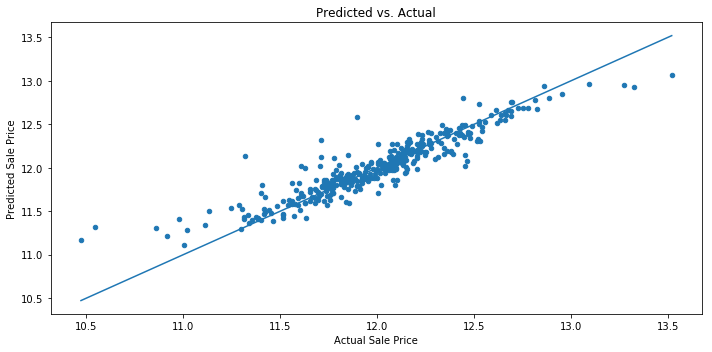

In [117]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)
model_rf = RandomForestRegressor(n_estimators=500, n_jobs=-1)

model_rf.fit(X_train1, y_train1)
rf_pred = model_rf.predict(X_test1)

plt.figure(figsize=(10, 5))
plt.scatter(y_test1, rf_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)])
plt.tight_layout()

In [118]:
model_rf.fit(X_train, y_train)
rf_pred_log = model_rf.predict(X_test)

In [119]:
rf_pred_log

array([ 11.74514476,  11.93670807,  12.09083413, ...,  11.94272549,
        11.62871194,  12.36026209])

In [120]:
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.expm1(rf_pred_log)})
submission.tail(1)

,Id,SalePrice
2918,2919,233341.37967


In [81]:
submission.to_csv("./output/sub-rf-30_03_2017.csv", index=False)

## Ridge regularisation

In [83]:
from sklearn.linear_model import Ridge, RidgeCV

In [84]:
model_rige = Ridge()

In [85]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

In [86]:
cv_ridge

[0.13841981114182578,
 0.13743018338390975,
 0.13486165627049837,
 0.1312241659458005,
 0.1284620142195069,
 0.127603300987154,
 0.12704223648734944,
 0.12717036723959668,
 0.12852299878948439,
 0.13064143692101421,
 0.133043019775411]

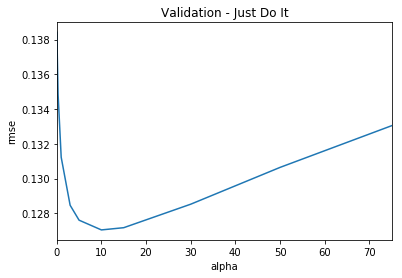

In [87]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [88]:
cv_ridge.min()

0.12704223648734944

In [89]:
# looks like the smallest error is with alpha = 10 
cv_ridge

0.05     0.138420
0.10     0.137430
0.30     0.134862
1.00     0.131224
3.00     0.128462
5.00     0.127603
10.00    0.127042
15.00    0.127170
30.00    0.128523
50.00    0.130641
75.00    0.133043
dtype: float64

In [90]:
# let train again model with alpha = 10
model_ridge = Ridge(alpha = 10).fit(X_train, y_train)
rmse_cv(model_ridge).mean()

0.12704223648734944

### predict and save

In [94]:
y_test_pred_log = model_ridge.predict(X_test)
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.expm1(y_test_pred_log)})
submission.to_csv("./output/sub-ridge-30_03_2017.csv", index=False)
submission.head()

,Id,SalePrice
1460,1461,118113.146107
1461,1462,152846.170517
1462,1463,181755.350754
1463,1464,197458.445245
1464,1465,198982.910886


## Linear regression with regularisation (lasso)

In [124]:
from sklearn.linear_model import LassoCV
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)


In [125]:
rmse_cv(model_lasso).mean()

0.12203213141209832

In [126]:
lasso_pred_log = model_lasso.predict(X_test)
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.expm1(lasso_pred_log)})
submission.to_csv("./output/sub-lasso-30_03_2017.csv", index=False)
submission.head()

,Id,SalePrice
1460,1461,119359.354694
1461,1462,152577.904688
1462,1463,180811.052798
1463,1464,197096.208156
1464,1465,201190.778838


## Xgboost

In [138]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

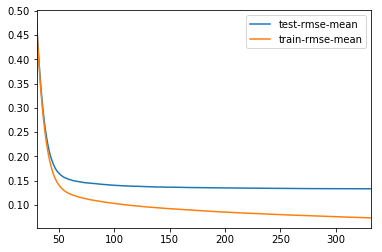

In [141]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [142]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [143]:
xgb_preds_log = model_xgb.predict(X_test)
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.expm1(xgb_preds_log)})
submission.to_csv("./output/sub-xgb-30_03_2017.csv", index=False)
submission.head()

,Id,SalePrice
1460,1461,120807.914062
1461,1462,156783.328125
1462,1463,184880.078125
1463,1464,190933.578125
1464,1465,187652.609375


## GradientBoosting Regressor

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
params = {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}

model_gbm = GradientBoostingRegressor(**params)
model_gbm.fit(X_train, y_train)

rmse_cv(model_gbm).mean()

0.20791978874828368

## Save models

## Ensembling (move ensembling to separate notebook)

In [146]:
pred_rd = np.expm1(model_rf.predict(X_test))
pred_lasso = np.expm1(model_lasso.predict(X_test))
pred_ridge = np.expm1(model_ridge.predict(X_test))
pred_xgb = np.expm1(model_xgb.predict(X_test))

predictions = pd.DataFrame({"rf":pred_rd, 
                            "lasso":pred_lasso, 
                            "ridge":pred_ridge,
                            "xgb": pred_xgb})
# predictions.plot(x = "rf", y = "ridge", kind = "scatter")
predictions.head()

,lasso,rf,ridge,xgb
0,119359.354694,126138.631422,118113.146107,120807.914062
1,152577.904688,152771.943903,152846.170517,156783.328125
2,180811.052798,178229.713026,181755.350754,184880.078125
3,197096.208156,179735.676443,197458.445245,190933.578125
4,201190.778838,196499.619014,198982.910886,187652.609375


### random forest + lasso (LB: 2.06308)

In [132]:
pred_ensemble_rf_lasso = 0.7*pred_rd + 0.3*pred_lasso
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':pred_ensemble_rf_lasso})
submission.to_csv("./output/sub-ensemble_rf_lasso-30_03_2017.csv", index=False)
submission.head()

,Id,SalePrice
1460,1461,124104.848404
1461,1462,152713.732139
1462,1463,179004.114958
1463,1464,184943.835957
1464,1465,197906.966962


### random forest + ridge (LB: 2.60388)

In [133]:
pred_ensemble_rf_ridge = 0.7*pred_rd + 0.3*pred_ridge
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':pred_ensemble_rf_ridge})
submission.to_csv("./output/sub-ensemble_rf_ridge-30_03_2017.csv", index=False)
submission.head()

,Id,SalePrice
1460,1461,123730.985828
1461,1462,152794.211887
1462,1463,179287.404344
1463,1464,185052.507083
1464,1465,197244.606576


### random forest + xgb (LB: 0.13264)

In [147]:
pred_ensemble_rf_xgb = 0.4*pred_rd + 0.6*pred_xgb
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':pred_ensemble_rf_xgb})
submission.to_csv("./output/sub-ensemble_rf_xgb-30_03_2017.csv", index=False)
submission.head()

,Id,SalePrice
1460,1461,122940.202569
1461,1462,155178.777561
1462,1463,182219.939898
1463,1464,186454.419015
1464,1465,191191.417918
